# Cox model

In [19]:
%load_ext autoreload
%autoreload 2

import os
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import lifelines
from lifelines import CoxPHFitter
from sklearn.model_selection import StratifiedKFold

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import neptune
import warnings
warnings.filterwarnings("ignore")
import shutil
import anndata as ad
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
dataset_name = "210226_cvd_gp_full_cluster"
path = "/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb"
data_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS/data"
dataset_path = f"{data_path}/3_datasets_post/{dataset_name}"

## Load data

In [21]:
def get_eid_map(h5ad):
    eids = np.expand_dims(h5ad.obs['eid'].values.astype(int), axis=-1)
    eid_map = pd.DataFrame(np.concatenate([eids, h5ad.X], axis=1),
                                columns=['eid'] + h5ad.var.index.values.tolist())
    eid_map = eid_map.astype({'eid': 'int32'})#.set_index('eid')
    return eid_map

In [4]:
partitions = [str(p) for p in range(10)]
splits = ["train", "valid", "test"]

In [31]:
eids_incl = pd.read_feather(f"{dataset_path}/data_excl.feather").eid.to_list()
excl = True
if excl==True: data_all = {partition: {split: pd.read_feather(f"{dataset_path}/partition_{partition}/{split}/data_imputed_normalized.feather").query("eid ==@eids_incl").set_index("eid") for split in splits} for partition in tqdm(partitions)}
else: data_all = {partition: {split: pd.read_feather(f"{dataset_path}/partition_{partition}/{split}/data_imputed_normalized.feather").set_index("eid") for split in splits} for partition in tqdm(partitions)}

  0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
features = {}
#features["pgs"] = ['PGS000011', 'PGS000013', 'PGS000016', 'PGS000018', 'PGS000039', 'PGS000057', 
#                   'PGS000058', 'PGS000059', 'PGS000116', 'PGS000117', 'PGS000192', 'PGS000296']
features["pgs"] = ['PGS000011', 'PGS000057', 'PGS000058', 'PGS000059']

In [33]:
basics = [
'age_at_recruitment',
'ethnic_background_0.0',
'ethnic_background_1.0',
'ethnic_background_2.0',#na 2 -> 5
'ethnic_background_3.0',
'ethnic_background_4.0',
'townsend_deprivation_index_at_recruitment',
'sex'
]
questionnaire = [
'overall_health_rating_0.0',
'overall_health_rating_1.0',
'overall_health_rating_2.0',
'overall_health_rating_3.0',
'smoking_status_0.0',
'smoking_status_1.0',
'smoking_status_2.0',
]
measurements = [
'body_mass_index_bmi',
'weight',
"standing_height",
'systolic_blood_pressure',
'diastolic_blood_pressure',
]

labs = [
"cholesterol",
"hdl_cholesterol",
"ldl_direct",
"triglycerides"
]

family_history = [
'fh_heart_disease',
]

diagnoses = [
'diabetes1',
'diabetes2',
'chronic_kidney_disease',
'atrial_fibrillation',
'migraine',
'rheumatoid_arthritis',
'systemic_lupus_erythematosus',
'severe_mental_illness',
'erectile_dysfunction',
]

medications = [
"antihypertensives",
"ass",
"atypical_antipsychotics",
"glucocorticoids"
]

feature_dict = {
"pgs": [],
"basics": basics,
"questionnaire": questionnaire,
"measurements": measurements,
"labs": labs,
"family_history": family_history,
"medications": medications,
"diagnoses": diagnoses
}

In [34]:
features["clinical"] = [f for group_list in feature_dict.values() for f in group_list]
features["clinical_pgs"] = features["pgs"]+[f for group_list in feature_dict.values() for f in group_list]

## Predictions

In [35]:
endpoint = "MACE"; event=endpoint+'_event'; time=endpoint+'_event_time'
groups = ["clinical", "clinical_pgs"]

In [36]:
data = {}
for group in tqdm(groups): 
    data[group] = {"features":features[group]+[time, event]}
    for partition in partitions: 
        data[group][partition] = {}
        for split in splits: data[group][partition][split] = data_all[partition][split].loc[:, data[group]["features"]].copy()

  0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
from lifelines.utils import concordance_index
def fit_predict_coxph(data_h5ad, group, partition, time, event, pickle_path):
    cph = CoxPHFitter()
    train_data, val_data, test_data = data_h5ad[group][partition]["train"], data_h5ad[group][partition]["valid"], data_h5ad[group][partition]["test"]
    covariates_with_tte = data[group]["features"]
    cph.fit(train_data[covariates_with_tte], duration_col=time, event_col=event, show_progress=True, step_size=0.5)
    pickle.dump(cph, open(pickle_path, "wb" ) )
    print(concordance_index(val_data[time], -cph.predict_partial_hazard(val_data[covariates_with_tte]), val_data[event]))
    #display(val_data[covariates_with_tte])
    surv_train = 1-cph.predict_survival_function(train_data[covariates_with_tte], times=[11]) # as years + 1
    surv_train_all = 1-cph.predict_survival_function(train_data[covariates_with_tte], times=[t for t in range(1,27)])
    display(surv_train)
    surv_val = 1-cph.predict_survival_function(val_data[covariates_with_tte], times=[11]) # as years + 1  
    surv_val_all = 1-cph.predict_survival_function(val_data[covariates_with_tte], times=[t for t in range(1,27)]) # as years + 1  
    surv_test = 1-cph.predict_survival_function(test_data[covariates_with_tte], times=[11]) # as years + 1  
    surv_test_all = 1-cph.predict_survival_function(test_data[covariates_with_tte], times=[t for t in range(1,27)]) # as years + 1  
    pred = {"train":train_data.reset_index()[["eid"]],
            "val":val_data.reset_index()[["eid"]],
           "test":test_data.reset_index()[["eid"]],}
    pred["train"][f"score_COX_{group}"] = surv_train.iloc[0].to_list()
    pred["val"][f"score_COX_{group}"] = surv_val.iloc[0].to_list()
    pred["test"][f"score_COX_{group}"] = surv_test.iloc[0].to_list()
    
    for t in range(1, 27):
        prefix = f"0_{t}_Ft_COX_{group}"
        pred["train"][prefix] = surv_train_all.T[t].to_list()
        pred["val"][prefix] = surv_val_all.T[t].to_list()
        pred["test"][prefix] = surv_test_all.T[t].to_list()
        
    return pd.concat([pred["train"].assign(partition=partition, split="train"), pred["val"].assign(partition=partition, split="valid"), pred["test"].assign(partition=partition, split="test")])

In [38]:
predictions_dict = {}
for group in tqdm(groups):
    predictions_dict[group] = {}
    for partition in partitions:
        tqdm.write(group)
        tqdm.write(partition)
        predictions_dict[group][partition] = fit_predict_coxph(data.copy(), group, partition, time, event, f"{dataset_path}/partition_{partition}/cox_{group}.p")

  0%|          | 0/2 [00:00<?, ?it/s]

clinical
0
Iteration 1: norm_delta = 0.84740, step_size = 0.5000, log_lik = -302789.67372, newton_decrement = 8760.47734, seconds_since_start = 3.8
Iteration 2: norm_delta = 0.40220, step_size = 0.5000, log_lik = -296354.04940, newton_decrement = 2090.87293, seconds_since_start = 7.6
Iteration 3: norm_delta = 0.22814, step_size = 0.5000, log_lik = -294773.26721, newton_decrement = 609.12739, seconds_since_start = 11.5
Iteration 4: norm_delta = 0.10348, step_size = 0.6000, log_lik = -294257.15345, newton_decrement = 113.73696, seconds_since_start = 15.3
Iteration 5: norm_delta = 0.03201, step_size = 0.7200, log_lik = -294151.61387, newton_decrement = 10.16387, seconds_since_start = 19.1
Iteration 6: norm_delta = 0.00470, step_size = 0.8640, log_lik = -294141.60080, newton_decrement = 0.20941, seconds_since_start = 22.9
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294141.39119, newton_decrement = 0.00000, seconds_since_start = 26.8
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5774080,0.800912,1,0,0,0,0,-0.807565,1.0,0,1,...,False,False,False,False,False,False,False,False,10.866530,0
5774091,0.924494,1,0,0,0,0,-0.960384,1.0,0,0,...,False,False,False,False,False,False,False,False,11.835729,0
5774108,0.553747,1,0,0,0,0,0.461605,0.0,0,1,...,True,False,False,False,False,False,False,False,10.546201,0
5774114,-0.187746,1,0,0,0,0,0.433239,0.0,1,0,...,False,True,False,False,True,False,True,False,10.915811,0
5774127,0.553747,1,0,0,0,0,2.563782,1.0,1,0,...,False,False,False,False,False,False,False,True,11.367556,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,-1.670733,0,0,1,0,0,0.034317,1.0,0,1,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,-1.670733,1,0,0,0,0,0.431740,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.423569,1,0,0,0,0,-0.263493,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0


,1000018,1000020,1000037,1000043,1000092,1000107,1000110,1000128,1000135,1000144,...,5773972,5773983,5773999,5774009,5774017,5774024,5774038,5774052,5774063,5774075
11.0,0.058397,0.138465,0.041485,0.136647,0.092353,0.018787,0.014695,0.01385,0.017988,0.061392,...,0.148328,0.261395,0.068467,0.127451,0.029612,0.052306,0.047576,0.010642,0.014388,0.095631


clinical
1
Iteration 1: norm_delta = 0.84042, step_size = 0.5000, log_lik = -301918.37352, newton_decrement = 8782.58025, seconds_since_start = 3.8
Iteration 2: norm_delta = 0.40627, step_size = 0.5000, log_lik = -295456.62162, newton_decrement = 2114.35338, seconds_since_start = 7.7
Iteration 3: norm_delta = 0.23122, step_size = 0.5000, log_lik = -293857.97662, newton_decrement = 616.65662, seconds_since_start = 11.5
Iteration 4: norm_delta = 0.10500, step_size = 0.6000, log_lik = -293335.46432, newton_decrement = 115.17985, seconds_since_start = 15.3
Iteration 5: norm_delta = 0.03241, step_size = 0.7200, log_lik = -293228.59034, newton_decrement = 10.27859, seconds_since_start = 19.0
Iteration 6: norm_delta = 0.00472, step_size = 0.8640, log_lik = -293218.46552, newton_decrement = 0.21082, seconds_since_start = 22.8
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293218.25453, newton_decrement = 0.00000, seconds_since_start = 26.6
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773972,1.170062,1,0,0,0,0,-0.347682,1.0,0,1,...,False,False,False,False,False,False,False,False,10.420260,0
5773983,1.540685,1,0,0,0,0,-0.630278,0.0,1,0,...,False,False,True,False,False,False,False,False,12.364134,0
5773999,-0.312430,1,0,0,0,0,-0.415273,1.0,0,1,...,False,False,False,True,False,False,False,False,11.342916,0
5774009,0.922980,1,0,0,0,0,-1.264710,1.0,0,1,...,False,False,False,False,False,False,False,False,11.463381,0
5774017,-1.177217,1,0,0,0,0,1.430013,0.0,0,1,...,False,False,False,False,False,False,False,False,10.595483,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,-1.671381,0,0,1,0,0,0.035651,1.0,0,1,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,-1.671381,1,0,0,0,0,0.433637,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.424299,1,0,0,0,0,-0.262581,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0


,1000018,1000020,1000043,1000079,1000084,1000092,1000107,1000110,1000128,1000135,...,5773814,5773827,5773840,5773871,5773886,5773895,5773928,5773935,5773944,5773961
11.0,0.056674,0.139445,0.13621,0.080178,0.057933,0.09166,0.018393,0.014255,0.013792,0.01802,...,0.113922,0.108543,0.034103,0.06617,0.804845,0.013291,0.024577,0.025625,0.036494,0.033593


clinical
2
Iteration 1: norm_delta = 0.83461, step_size = 0.5000, log_lik = -303934.60837, newton_decrement = 8899.23295, seconds_since_start = 3.8
Iteration 2: norm_delta = 0.40527, step_size = 0.5000, log_lik = -297388.53639, newton_decrement = 2144.25117, seconds_since_start = 7.9
Iteration 3: norm_delta = 0.23083, step_size = 0.5000, log_lik = -295767.17692, newton_decrement = 626.21041, seconds_since_start = 11.8
Iteration 4: norm_delta = 0.10507, step_size = 0.6000, log_lik = -295236.52115, newton_decrement = 117.15378, seconds_since_start = 15.7
Iteration 5: norm_delta = 0.03251, step_size = 0.7200, log_lik = -295127.80684, newton_decrement = 10.47061, seconds_since_start = 19.5
Iteration 6: norm_delta = 0.00475, step_size = 0.8640, log_lik = -295117.49239, newton_decrement = 0.21504, seconds_since_start = 23.2
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -295117.27717, newton_decrement = 0.00000, seconds_since_start = 27.2
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773808,-1.670824,1,0,0,0,0,-0.844251,1.0,0,1,...,False,False,False,False,False,False,False,False,10.685832,0
5773814,0.429000,1,0,0,0,0,0.187428,1.0,0,1,...,False,False,False,True,False,False,False,False,13.100616,0
5773827,0.676039,1,0,0,0,0,-0.693672,1.0,0,1,...,False,False,False,False,False,False,False,False,10.861054,0
5773840,-1.053228,1,0,0,0,0,2.262139,1.0,0,0,...,False,False,False,False,False,False,False,False,11.789185,0
5773871,0.429000,1,0,0,0,0,-0.368867,1.0,0,1,...,False,False,False,False,False,False,False,False,11.222450,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,-1.670824,0,0,1,0,0,0.035776,1.0,0,1,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,-1.670824,1,0,0,0,0,0.433824,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025173,0.058443,1,0,0,0,0,-0.172037,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000135,...,5773685,5773694,5773702,5773723,5773730,5773741,5773759,5773764,5773777,5773796
11.0,0.058533,0.140717,0.053771,0.140815,0.079569,0.058687,0.092992,0.01816,0.014488,0.017761,...,0.057012,0.048667,0.107531,0.024425,0.054355,0.057154,0.277623,0.237808,0.03789,0.011284


clinical
3
Iteration 1: norm_delta = 0.83041, step_size = 0.5000, log_lik = -304005.99770, newton_decrement = 8799.39988, seconds_since_start = 3.8
Iteration 2: norm_delta = 0.41042, step_size = 0.5000, log_lik = -297537.13319, newton_decrement = 2107.94080, seconds_since_start = 7.8
Iteration 3: norm_delta = 0.23359, step_size = 0.5000, log_lik = -295943.30814, newton_decrement = 614.95995, seconds_since_start = 11.6
Iteration 4: norm_delta = 0.10610, step_size = 0.6000, log_lik = -295422.22582, newton_decrement = 114.89211, seconds_since_start = 15.5
Iteration 5: norm_delta = 0.03277, step_size = 0.7200, log_lik = -295315.61723, newton_decrement = 10.25611, seconds_since_start = 19.3
Iteration 6: norm_delta = 0.00478, step_size = 0.8640, log_lik = -295305.51441, newton_decrement = 0.21046, seconds_since_start = 23.3
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -295305.30377, newton_decrement = 0.00000, seconds_since_start = 27.1
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773935,-0.188933,1,0,0,0,0,-0.884220,0.0,0,1,...,False,False,False,False,False,False,False,False,12.821355,0
5773944,-1.053656,1,0,0,0,0,-0.477837,0.0,0,0,...,False,False,False,False,False,False,True,False,12.366872,0
5773956,1.046386,1,0,0,0,0,-1.042789,0.0,0,0,...,False,False,False,False,False,False,False,False,12.019165,0
5773961,0.675790,1,0,0,0,0,-1.315573,0.0,0,0,...,False,False,False,False,False,False,False,False,12.709103,0
5773972,1.169918,1,0,0,0,0,-0.347410,1.0,0,1,...,False,False,False,False,False,False,False,False,10.420260,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,-1.671315,0,0,1,0,0,0.036094,1.0,0,1,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,-1.671315,1,0,0,0,0,0.434258,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.424251,1,0,0,0,0,-0.262270,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0


,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,1000135,...,5773759,5773788,5773808,5773814,5773827,5773871,5773886,5773895,5773907,5773928
11.0,0.142107,0.055649,0.139489,0.077657,0.057368,0.096656,0.018811,0.014662,0.013892,0.018299,...,0.273173,0.011538,0.02891,0.114676,0.109835,0.071728,0.827529,0.013538,0.068394,0.02442


clinical
4
Iteration 1: norm_delta = 0.86923, step_size = 0.5000, log_lik = -302864.07070, newton_decrement = 8837.27278, seconds_since_start = 3.8
Iteration 2: norm_delta = 0.40674, step_size = 0.5000, log_lik = -296366.86382, newton_decrement = 2122.31770, seconds_since_start = 7.8
Iteration 3: norm_delta = 0.22958, step_size = 0.5000, log_lik = -294762.08582, newton_decrement = 619.79745, seconds_since_start = 11.8
Iteration 4: norm_delta = 0.10393, step_size = 0.6000, log_lik = -294236.86718, newton_decrement = 115.96211, seconds_since_start = 15.9
Iteration 5: norm_delta = 0.03211, step_size = 0.7200, log_lik = -294129.25507, newton_decrement = 10.37426, seconds_since_start = 19.7
Iteration 6: norm_delta = 0.00470, step_size = 0.8640, log_lik = -294119.03473, newton_decrement = 0.21365, seconds_since_start = 23.5
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294118.82089, newton_decrement = 0.00000, seconds_since_start = 27.3
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5772854,-0.188141,1,0,0,0,0,0.471387,1.0,0,1,...,False,False,False,False,False,False,False,False,12.566735,1
5772869,0.058844,1,0,0,0,0,0.116279,1.0,0,1,...,False,False,False,False,False,False,False,False,12.353183,0
5772881,-1.299574,1,0,0,0,0,-0.732901,1.0,0,1,...,False,False,False,False,False,False,False,False,10.710472,0
5772897,0.429322,1,0,0,0,0,-0.390127,1.0,0,1,...,False,False,False,False,False,False,False,False,12.429843,0
5772905,-1.423067,1,0,0,0,0,1.355080,0.0,1,0,...,False,False,False,False,False,False,True,False,11.665982,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,-1.670052,0,0,1,0,0,0.036270,1.0,0,1,...,False,False,False,False,False,False,False,False,11.879535,0
6025165,-1.423067,1,0,0,0,0,-0.262191,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,0.058844,1,0,0,0,0,-0.171670,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000128,1000144,...,5772709,5772717,5772724,5772738,5772752,5772763,5772775,5772780,5772791,5772848
11.0,0.057609,0.140581,0.059015,0.136727,0.07811,0.057688,0.096069,0.018657,0.013703,0.059786,...,0.076225,0.051219,0.156717,0.032594,0.086405,0.158096,0.018065,0.050984,0.116584,0.126888


clinical
5
Iteration 1: norm_delta = 0.83871, step_size = 0.5000, log_lik = -303530.87696, newton_decrement = 8798.90133, seconds_since_start = 4.2
Iteration 2: norm_delta = 0.40518, step_size = 0.5000, log_lik = -297055.30290, newton_decrement = 2115.55485, seconds_since_start = 7.9
Iteration 3: norm_delta = 0.23031, step_size = 0.5000, log_lik = -295455.77368, newton_decrement = 616.93414, seconds_since_start = 11.9
Iteration 4: norm_delta = 0.10463, step_size = 0.6000, log_lik = -294933.01653, newton_decrement = 115.29343, seconds_since_start = 15.9
Iteration 5: norm_delta = 0.03236, step_size = 0.7200, log_lik = -294826.03053, newton_decrement = 10.30417, seconds_since_start = 20.0
Iteration 6: norm_delta = 0.00474, step_size = 0.8640, log_lik = -294815.87959, newton_decrement = 0.21200, seconds_since_start = 23.8
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294815.66740, newton_decrement = 0.00000, seconds_since_start = 27.6
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773935,-0.188183,1,0,0,0,0,-0.884706,0.0,0,1,...,False,False,False,False,False,False,False,False,12.821355,0
5773944,-1.052831,1,0,0,0,0,-0.478805,0.0,0,0,...,False,False,False,False,False,False,True,False,12.366872,0
5773956,1.047030,1,0,0,0,0,-1.043086,0.0,0,0,...,False,False,False,False,False,False,False,False,12.019165,0
5773961,0.676466,1,0,0,0,0,-1.315546,0.0,0,0,...,False,False,False,False,False,False,False,False,12.709103,0
5773972,1.170551,1,0,0,0,0,-0.348533,1.0,0,1,...,False,False,False,False,False,False,False,False,10.420260,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,-1.670438,1,0,0,0,0,0.432205,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.423395,1,0,0,0,0,-0.263495,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,0.058860,1,0,0,0,0,-0.173111,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,...,5773788,5773796,5773814,5773827,5773840,5773871,5773886,5773895,5773907,5773928
11.0,0.058658,0.141535,0.075851,0.135895,0.077556,0.056996,0.093573,0.018681,0.014801,0.013719,...,0.010142,0.011565,0.115478,0.11029,0.034197,0.08507,0.807532,0.013336,0.0676,0.023896


clinical
6
Iteration 1: norm_delta = 0.85460, step_size = 0.5000, log_lik = -302584.48904, newton_decrement = 8891.78043, seconds_since_start = 3.8
Iteration 2: norm_delta = 0.41090, step_size = 0.5000, log_lik = -296057.11273, newton_decrement = 2124.11951, seconds_since_start = 7.8
Iteration 3: norm_delta = 0.23321, step_size = 0.5000, log_lik = -294451.10345, newton_decrement = 619.48442, seconds_since_start = 12.0
Iteration 4: norm_delta = 0.10594, step_size = 0.6000, log_lik = -293926.18102, newton_decrement = 115.78936, seconds_since_start = 16.2
Iteration 5: norm_delta = 0.03278, step_size = 0.7200, log_lik = -293818.73382, newton_decrement = 10.35032, seconds_since_start = 20.4
Iteration 6: norm_delta = 0.00480, step_size = 0.8640, log_lik = -293808.53737, newton_decrement = 0.21297, seconds_since_start = 24.5
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293808.32421, newton_decrement = 0.00000, seconds_since_start = 28.4
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5774024,1.293981,1,0,0,0,0,-0.080038,0.0,0,1,...,False,False,False,False,False,False,False,False,10.921287,0
5774038,-1.917651,0,0,0,0,0,2.741456,1.0,0,0,...,False,False,False,False,False,False,False,False,11.148528,0
5774052,-2.041175,1,0,0,0,0,-1.159937,1.0,0,1,...,False,False,False,False,False,False,False,False,11.561944,0
5774063,-0.929457,1,0,0,0,0,-0.335110,0.0,0,1,...,False,False,False,False,False,False,False,False,11.126626,0
5774080,0.799883,1,0,0,0,0,-0.807184,1.0,0,1,...,False,False,False,False,False,False,False,False,10.866530,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,-1.670602,1,0,0,0,0,0.433342,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.423554,1,0,0,0,0,-0.262575,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,0.058738,1,0,0,0,0,-0.172163,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000037,1000043,1000079,1000084,1000110,1000128,1000135,1000144,1000156,...,5773928,5773935,5773944,5773956,5773961,5773972,5773983,5773999,5774009,5774017
11.0,0.058709,0.05642,0.139815,0.07789,0.056702,0.014441,0.013639,0.017835,0.057146,0.018596,...,0.023841,0.025356,0.037475,0.044238,0.041993,0.149844,0.265411,0.067405,0.129226,0.029213


clinical
7
Iteration 1: norm_delta = 0.87240, step_size = 0.5000, log_lik = -302470.77013, newton_decrement = 8822.16059, seconds_since_start = 3.8
Iteration 2: norm_delta = 0.40721, step_size = 0.5000, log_lik = -295988.64579, newton_decrement = 2114.44720, seconds_since_start = 7.8
Iteration 3: norm_delta = 0.23081, step_size = 0.5000, log_lik = -294389.78193, newton_decrement = 617.82255, seconds_since_start = 11.6
Iteration 4: norm_delta = 0.10486, step_size = 0.6000, log_lik = -293866.21506, newton_decrement = 115.66778, seconds_since_start = 15.5
Iteration 5: norm_delta = 0.03244, step_size = 0.7200, log_lik = -293758.87451, newton_decrement = 10.34847, seconds_since_start = 19.3
Iteration 6: norm_delta = 0.00474, step_size = 0.8640, log_lik = -293748.67989, newton_decrement = 0.21286, seconds_since_start = 23.2
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293748.46684, newton_decrement = 0.00000, seconds_since_start = 27.1
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5774203,-0.189260,1,0,0,0,0,0.749576,1.0,0,1,...,False,False,False,False,False,False,False,False,6.743326,1
5774211,-0.312817,1,0,0,0,0,-1.299185,0.0,0,1,...,False,False,True,False,False,False,False,False,12.659822,0
5774245,-0.930601,1,0,0,0,0,2.044694,1.0,0,1,...,False,False,False,False,False,False,False,False,12.640657,0
5774267,-1.177714,1,0,0,0,0,-0.723440,1.0,0,1,...,False,False,False,False,False,False,False,False,12.859685,0
5774274,-1.177714,0,1,0,0,0,0.494199,0.0,0,0,...,False,False,False,False,True,False,False,False,10.830938,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,-1.671941,1,0,0,0,0,0.433481,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.424828,1,0,0,0,0,-0.262766,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,0.057853,1,0,0,0,0,-0.172311,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000079,1000084,1000092,1000107,1000110,1000128,1000135,...,5774091,5774108,5774114,5774127,5774139,5774140,5774153,5774162,5774171,5774186
11.0,0.056108,0.139779,0.054076,0.077655,0.055557,0.094508,0.01867,0.014553,0.01375,0.017445,...,0.119721,0.08067,0.089872,0.275772,0.018271,0.023672,0.028315,0.039754,0.068492,0.039113


clinical
8
Iteration 1: norm_delta = 0.88350, step_size = 0.5000, log_lik = -303600.50186, newton_decrement = 8863.09158, seconds_since_start = 3.9
Iteration 2: norm_delta = 0.40709, step_size = 0.5000, log_lik = -297083.72871, newton_decrement = 2125.68633, seconds_since_start = 7.7
Iteration 3: norm_delta = 0.23170, step_size = 0.5000, log_lik = -295476.42684, newton_decrement = 620.60038, seconds_since_start = 11.5
Iteration 4: norm_delta = 0.10545, step_size = 0.6000, log_lik = -294950.53981, newton_decrement = 116.04341, seconds_since_start = 15.3
Iteration 5: norm_delta = 0.03261, step_size = 0.7200, log_lik = -294842.85895, newton_decrement = 10.36572, seconds_since_start = 19.1
Iteration 6: norm_delta = 0.00476, step_size = 0.8640, log_lik = -294832.64800, newton_decrement = 0.21279, seconds_since_start = 23.1
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294832.43504, newton_decrement = 0.00000, seconds_since_start = 27.1
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5774504,0.676477,1,0,0,0,0,0.707834,0.0,1,0,...,False,True,False,True,True,False,False,False,11.534565,0
5774516,-1.177732,1,0,0,0,0,0.271163,1.0,0,1,...,False,False,False,False,False,False,False,False,12.725530,0
5774531,0.923704,1,0,0,0,0,-0.080066,1.0,0,1,...,False,True,False,False,False,False,False,False,10.305270,0
5774550,-0.683276,1,0,0,0,0,1.159483,0.0,1,0,...,False,False,False,False,False,False,False,False,10.524298,0
5774565,0.058407,1,0,0,0,0,1.180651,1.0,0,1,...,False,False,False,False,False,False,False,False,11.534565,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,-1.672187,1,0,0,0,0,0.432835,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.424959,1,0,0,0,0,-0.262796,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,0.058407,1,0,0,0,0,-0.172421,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,...,5774359,5774364,5774396,5774405,5774420,5774443,5774451,5774466,5774479,5774484
11.0,0.056757,0.141078,0.05026,0.139246,0.078742,0.058,0.09465,0.018437,0.014367,0.013738,...,0.042405,0.039005,0.046237,0.011547,0.132303,0.01077,0.069881,0.021488,0.047245,0.043107


clinical
9
Iteration 1: norm_delta = 0.84487, step_size = 0.5000, log_lik = -302369.03502, newton_decrement = 8802.10427, seconds_since_start = 3.8
Iteration 2: norm_delta = 0.40507, step_size = 0.5000, log_lik = -295905.60665, newton_decrement = 2101.24037, seconds_since_start = 7.9
Iteration 3: norm_delta = 0.22850, step_size = 0.5000, log_lik = -294316.81957, newton_decrement = 613.29160, seconds_since_start = 11.6
Iteration 4: norm_delta = 0.10333, step_size = 0.6000, log_lik = -293797.12542, newton_decrement = 114.70320, seconds_since_start = 15.4
Iteration 5: norm_delta = 0.03191, step_size = 0.7200, log_lik = -293690.68288, newton_decrement = 10.25953, seconds_since_start = 19.2
Iteration 6: norm_delta = 0.00467, step_size = 0.8640, log_lik = -293680.57560, newton_decrement = 0.21129, seconds_since_start = 23.0
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293680.36412, newton_decrement = 0.00000, seconds_since_start = 26.8
Iteration 8: norm_delta = 0.00000, 

,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,townsend_deprivation_index_at_recruitment,sex,overall_health_rating_0.0,overall_health_rating_1.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5774222,-0.684344,1,0,0,0,0,-1.075855,0.0,0,0,...,False,False,False,False,False,False,False,False,12.851472,0
5774236,1.045715,1,0,0,0,0,-0.901500,0.0,0,0,...,False,False,False,False,False,False,False,False,11.518138,0
5774245,-0.931495,1,0,0,0,0,2.044590,1.0,0,1,...,False,False,False,False,False,False,False,False,12.640657,0
5774267,-1.178647,1,0,0,0,0,-0.724010,1.0,0,1,...,False,False,False,False,False,False,False,False,12.859685,0
5774274,-1.178647,0,1,0,0,0,0.493834,0.0,0,0,...,False,False,False,False,True,False,False,False,10.830938,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,-1.672949,1,0,0,0,0,0.433106,0.0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,-1.425798,1,0,0,0,0,-0.263259,0.0,0,1,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,0.057110,1,0,0,0,0,-0.172788,1.0,0,1,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,...,5774108,5774114,5774127,5774140,5774153,5774162,5774171,5774186,5774203,5774211
11.0,0.057459,0.139022,0.041763,0.135056,0.077909,0.056445,0.092904,0.018459,0.01446,0.013692,...,0.080612,0.092105,0.270525,0.029869,0.029275,0.039521,0.068504,0.042902,0.097103,0.04952


clinical_pgs
0
Iteration 1: norm_delta = 0.85142, step_size = 0.5000, log_lik = -302789.67372, newton_decrement = 9031.28749, seconds_since_start = 4.1
Iteration 2: norm_delta = 0.40595, step_size = 0.5000, log_lik = -296151.00190, newton_decrement = 2159.31329, seconds_since_start = 8.2
Iteration 3: norm_delta = 0.23022, step_size = 0.5000, log_lik = -294518.76240, newton_decrement = 627.15448, seconds_since_start = 12.3
Iteration 4: norm_delta = 0.10441, step_size = 0.6000, log_lik = -293987.45099, newton_decrement = 116.82710, seconds_since_start = 16.5
Iteration 5: norm_delta = 0.03230, step_size = 0.7200, log_lik = -293879.05374, newton_decrement = 10.42320, seconds_since_start = 20.6
Iteration 6: norm_delta = 0.00474, step_size = 0.8640, log_lik = -293868.78563, newton_decrement = 0.21450, seconds_since_start = 24.7
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293868.57093, newton_decrement = 0.00000, seconds_since_start = 28.9
Iteration 8: norm_delta = 0.000

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5774080,0.504130,0.231645,0.999551,0.355905,0.800912,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.866530,0
5774091,-0.547183,-0.194042,0.555937,-0.605116,0.924494,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.835729,0
5774108,0.671261,1.873436,0.948709,0.418592,0.553747,1,0,0,0,0,...,True,False,False,False,False,False,False,False,10.546201,0
5774114,1.530158,0.927932,1.055698,0.588455,-0.187746,1,0,0,0,0,...,False,True,False,False,True,False,True,False,10.915811,0
5774127,-0.329992,1.283870,0.316242,0.740566,0.553747,1,0,0,0,0,...,False,False,False,False,False,False,False,True,11.367556,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,0.519527,0.240938,1.351894,-1.702280,-1.670733,0,0,1,0,0,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,0.912528,0.952614,0.123178,0.551615,-1.670733,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.216185,-0.497419,-0.978002,-0.698478,-1.423569,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0


,1000018,1000020,1000037,1000043,1000092,1000107,1000110,1000128,1000135,1000144,...,5773972,5773983,5773999,5774009,5774017,5774024,5774038,5774052,5774063,5774075
11.0,0.051762,0.139502,0.050648,0.138641,0.080354,0.015464,0.01539,0.010518,0.014647,0.053411,...,0.182642,0.284285,0.068859,0.175677,0.026107,0.049846,0.041749,0.012006,0.015832,0.088104


clinical_pgs
1
Iteration 1: norm_delta = 0.84363, step_size = 0.5000, log_lik = -301918.37352, newton_decrement = 9029.07588, seconds_since_start = 4.2
Iteration 2: norm_delta = 0.40934, step_size = 0.5000, log_lik = -295271.53723, newton_decrement = 2178.42860, seconds_since_start = 8.4
Iteration 3: norm_delta = 0.23296, step_size = 0.5000, log_lik = -293624.65731, newton_decrement = 633.93448, seconds_since_start = 12.5
Iteration 4: norm_delta = 0.10578, step_size = 0.6000, log_lik = -293087.56072, newton_decrement = 118.20847, seconds_since_start = 16.7
Iteration 5: norm_delta = 0.03265, step_size = 0.7200, log_lik = -292977.88323, newton_decrement = 10.53748, seconds_since_start = 21.2
Iteration 6: norm_delta = 0.00476, step_size = 0.8640, log_lik = -292967.50367, newton_decrement = 0.21597, seconds_since_start = 25.4
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -292967.28752, newton_decrement = 0.00000, seconds_since_start = 29.6
Iteration 8: norm_delta = 0.000

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773972,0.155023,2.021287,1.119648,1.306834,1.170062,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.420260,0
5773983,0.045591,1.002189,0.669587,0.360903,1.540685,1,0,0,0,0,...,False,False,True,False,False,False,False,False,12.364134,0
5773999,-0.288240,0.721837,-0.352591,0.533248,-0.312430,1,0,0,0,0,...,False,False,False,True,False,False,False,False,11.342916,0
5774009,2.853341,1.919377,1.044842,1.779799,0.922980,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.463381,0
5774017,-0.806272,-0.806710,-0.227310,-0.698540,-1.177217,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.595483,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,0.518334,0.239664,1.351434,-1.700856,-1.671381,0,0,1,0,0,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,0.911089,0.951234,0.123185,0.550534,-1.671381,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.214556,-0.498583,-0.977576,-0.698169,-1.424299,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0


,1000018,1000020,1000043,1000079,1000084,1000092,1000107,1000110,1000128,1000135,...,5773814,5773827,5773840,5773871,5773886,5773895,5773928,5773935,5773944,5773961
11.0,0.050676,0.141886,0.138537,0.082222,0.058141,0.079901,0.015138,0.014921,0.011979,0.014592,...,0.128338,0.107188,0.038427,0.084716,0.789787,0.011945,0.027964,0.021882,0.030506,0.035277


clinical_pgs
2
Iteration 1: norm_delta = 0.83836, step_size = 0.5000, log_lik = -303934.60837, newton_decrement = 9164.67613, seconds_since_start = 4.0
Iteration 2: norm_delta = 0.40845, step_size = 0.5000, log_lik = -297189.61863, newton_decrement = 2211.37629, seconds_since_start = 8.2
Iteration 3: norm_delta = 0.23265, step_size = 0.5000, log_lik = -295517.75359, newton_decrement = 644.14683, seconds_since_start = 12.4
Iteration 4: norm_delta = 0.10586, step_size = 0.6000, log_lik = -294971.96435, newton_decrement = 120.27386, seconds_since_start = 16.5
Iteration 5: norm_delta = 0.03275, step_size = 0.7200, log_lik = -294860.36274, newton_decrement = 10.73591, seconds_since_start = 20.7
Iteration 6: norm_delta = 0.00478, step_size = 0.8640, log_lik = -294849.78726, newton_decrement = 0.22031, seconds_since_start = 24.9
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294849.56676, newton_decrement = 0.00000, seconds_since_start = 29.3
Iteration 8: norm_delta = 0.000

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773808,-1.812692,-1.087006,-0.549280,-0.058962,-1.670824,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.685832,0
5773814,0.088857,0.072109,1.226257,0.417502,0.429000,1,0,0,0,0,...,False,False,False,True,False,False,False,False,13.100616,0
5773827,0.585491,-0.270818,-0.078308,-0.357968,0.676039,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.861054,0
5773840,0.419020,0.796243,0.816419,1.008088,-1.053228,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.789185,0
5773871,2.490407,1.869502,-0.031807,0.928714,0.429000,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.222450,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,0.517928,0.240124,1.351553,-1.702714,-1.670824,0,0,1,0,0,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,0.910754,0.951965,0.123146,0.550484,-1.670824,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025173,-1.548184,-1.500397,-1.129791,-1.285205,0.058443,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000135,...,5773685,5773694,5773702,5773723,5773730,5773741,5773759,5773764,5773777,5773796
11.0,0.051739,0.143324,0.063317,0.142969,0.082017,0.059062,0.080513,0.014764,0.015168,0.014462,...,0.06509,0.052095,0.114301,0.024714,0.054734,0.063695,0.327169,0.224753,0.033761,0.011513


clinical_pgs
3
Iteration 1: norm_delta = 0.83402, step_size = 0.5000, log_lik = -304005.99770, newton_decrement = 9072.55473, seconds_since_start = 4.0
Iteration 2: norm_delta = 0.41374, step_size = 0.5000, log_lik = -297332.54431, newton_decrement = 2176.30449, seconds_since_start = 8.3
Iteration 3: norm_delta = 0.23546, step_size = 0.5000, log_lik = -295687.34149, newton_decrement = 632.79383, seconds_since_start = 12.3
Iteration 4: norm_delta = 0.10692, step_size = 0.6000, log_lik = -295151.23722, newton_decrement = 117.89940, seconds_since_start = 16.5
Iteration 5: norm_delta = 0.03301, step_size = 0.7200, log_lik = -295041.85007, newton_decrement = 10.50411, seconds_since_start = 21.0
Iteration 6: norm_delta = 0.00481, step_size = 0.8640, log_lik = -295031.50347, newton_decrement = 0.21525, seconds_since_start = 25.1
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -295031.28803, newton_decrement = 0.00000, seconds_since_start = 29.2
Iteration 8: norm_delta = 0.000

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773935,-0.490263,-0.678900,-1.113311,-0.774262,-0.188933,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.821355,0
5773944,-0.585952,-1.316175,-1.439081,-0.168532,-1.053656,1,0,0,0,0,...,False,False,False,False,False,False,True,False,12.366872,0
5773956,0.831714,-0.373008,1.337478,-0.036029,1.046386,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.019165,0
5773961,0.189128,0.730102,0.475269,-0.585194,0.675790,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.709103,0
5773972,0.155354,2.023145,1.119482,1.307935,1.169918,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.420260,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,0.518852,0.240575,1.351386,-1.701416,-1.671315,0,0,1,0,0,...,False,False,False,False,False,False,False,False,11.879535,0
6025150,0.911811,0.952523,0.122509,0.551218,-1.671315,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.215434,-0.498064,-0.978815,-0.698175,-1.424251,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0


,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,1000135,...,5773759,5773788,5773808,5773814,5773827,5773871,5773886,5773895,5773907,5773928
11.0,0.143886,0.065885,0.141765,0.07961,0.057475,0.083325,0.015389,0.015373,0.01582,0.014933,...,0.320482,0.012762,0.024238,0.128839,0.107794,0.092878,0.810978,0.012141,0.094387,0.027914


clinical_pgs
4
Iteration 1: norm_delta = 0.87203, step_size = 0.5000, log_lik = -302864.07070, newton_decrement = 9093.83811, seconds_since_start = 4.2
Iteration 2: norm_delta = 0.40954, step_size = 0.5000, log_lik = -296174.71296, newton_decrement = 2186.56763, seconds_since_start = 8.4
Iteration 3: norm_delta = 0.23141, step_size = 0.5000, log_lik = -294521.63404, newton_decrement = 636.68630, seconds_since_start = 12.6
Iteration 4: norm_delta = 0.10486, step_size = 0.6000, log_lik = -293982.17890, newton_decrement = 118.85252, seconds_since_start = 16.7
Iteration 5: norm_delta = 0.03242, step_size = 0.7200, log_lik = -293871.89388, newton_decrement = 10.61692, seconds_since_start = 20.8
Iteration 6: norm_delta = 0.00475, step_size = 0.8640, log_lik = -293861.43487, newton_decrement = 0.21844, seconds_since_start = 24.9
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293861.21624, newton_decrement = 0.00000, seconds_since_start = 29.1
Iteration 8: norm_delta = 0.000

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5772854,-0.831473,-0.475716,-1.808277,-0.846440,-0.188141,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.566735,1
5772869,-0.355422,0.365418,-0.441591,-0.667018,0.058844,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.353183,0
5772881,2.001596,2.274987,2.729080,0.639929,-1.299574,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.710472,0
5772897,0.025154,0.671285,-2.087384,-0.207070,0.429322,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.429843,0
5772905,-0.434826,-0.526694,-0.655950,1.155849,-1.423067,1,0,0,0,0,...,False,False,False,False,False,False,True,False,11.665982,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025147,0.519168,0.239772,1.351487,-1.702124,-1.670052,0,0,1,0,0,...,False,False,False,False,False,False,False,False,11.879535,0
6025165,1.215796,-0.498806,-0.977772,-0.698864,-1.423067,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,-1.547780,-1.500870,-1.129805,-1.284712,0.058844,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000128,1000144,...,5772709,5772717,5772724,5772738,5772752,5772763,5772775,5772780,5772791,5772848
11.0,0.051065,0.14108,0.069313,0.138425,0.079897,0.0577,0.083881,0.015421,0.009871,0.062679,...,0.069355,0.050618,0.143826,0.025964,0.111714,0.163184,0.016832,0.044867,0.108301,0.129851


clinical_pgs
5
Iteration 1: norm_delta = 0.84122, step_size = 0.5000, log_lik = -303530.87696, newton_decrement = 9072.72533, seconds_since_start = 4.2
Iteration 2: norm_delta = 0.40846, step_size = 0.5000, log_lik = -296850.41665, newton_decrement = 2183.21770, seconds_since_start = 8.4
Iteration 3: norm_delta = 0.23223, step_size = 0.5000, log_lik = -295200.02498, newton_decrement = 634.71457, seconds_since_start = 12.7
Iteration 4: norm_delta = 0.10546, step_size = 0.6000, log_lik = -294662.27731, newton_decrement = 118.34724, seconds_since_start = 16.9
Iteration 5: norm_delta = 0.03261, step_size = 0.7200, log_lik = -294552.46665, newton_decrement = 10.56167, seconds_since_start = 21.1
Iteration 6: norm_delta = 0.00477, step_size = 0.8640, log_lik = -294542.06240, newton_decrement = 0.21709, seconds_since_start = 25.3
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294541.84512, newton_decrement = 0.00000, seconds_since_start = 29.5
Iteration 8: norm_delta = 0.000

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5773935,-0.489797,-0.678411,-1.111549,-0.775433,-0.188183,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.821355,0
5773944,-0.585514,-1.315263,-1.437158,-0.169347,-1.052831,1,0,0,0,0,...,False,False,False,False,False,False,True,False,12.366872,0
5773956,0.832557,-0.372722,1.338028,-0.036766,1.047030,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.019165,0
5773961,0.189787,0.729656,0.476245,-0.586254,0.676466,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.709103,0
5773972,0.156004,2.021840,1.120140,1.307987,1.170551,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.420260,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,0.912677,0.951929,0.123660,0.550825,-1.670438,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.216387,-0.497695,-0.977119,-0.699301,-1.423395,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,-1.547796,-1.499176,-1.129139,-1.285481,0.058860,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,...,5773788,5773796,5773814,5773827,5773840,5773871,5773886,5773895,5773907,5773928
11.0,0.051869,0.143412,0.086845,0.137761,0.079809,0.057252,0.081141,0.015235,0.015485,0.015103,...,0.011322,0.011908,0.129816,0.10873,0.038682,0.108642,0.791478,0.011928,0.092871,0.027278


clinical_pgs
6
Iteration 1: norm_delta = 0.85899, step_size = 0.5000, log_lik = -302584.48904, newton_decrement = 9175.49386, seconds_since_start = 4.5
Iteration 2: norm_delta = 0.41476, step_size = 0.5000, log_lik = -295844.59451, newton_decrement = 2195.75284, seconds_since_start = 8.8
Iteration 3: norm_delta = 0.23540, step_size = 0.5000, log_lik = -294184.68819, newton_decrement = 638.65516, seconds_since_start = 13.4
Iteration 4: norm_delta = 0.10687, step_size = 0.6000, log_lik = -293643.58442, newton_decrement = 119.15072, seconds_since_start = 17.6
Iteration 5: norm_delta = 0.03305, step_size = 0.7200, log_lik = -293533.02514, newton_decrement = 10.63882, seconds_since_start = 21.8
Iteration 6: norm_delta = 0.00484, step_size = 0.8640, log_lik = -293522.54476, newton_decrement = 0.21875, seconds_since_start = 26.0
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293522.32582, newton_decrement = 0.00000, seconds_since_start = 30.1
Iteration 8: norm_delta = 0.000

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5774024,-0.075828,0.366532,-1.306885,0.685723,1.293981,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.921287,0
5774038,0.535311,0.280271,-1.783581,-0.005484,-1.917651,0,0,0,0,0,...,False,False,False,False,False,False,False,False,11.148528,0
5774052,0.203838,0.595929,0.639736,1.206243,-2.041175,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.561944,0
5774063,0.186925,0.774948,1.092687,-0.206300,-0.929457,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.126626,0
5774080,0.504005,0.231593,0.999493,0.355184,0.799883,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.866530,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,0.912248,0.952768,0.123121,0.550732,-1.670602,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.215789,-0.497678,-0.978057,-0.698323,-1.423554,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,-1.546857,-1.499726,-1.130131,-1.284001,0.058738,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000037,1000043,1000079,1000084,1000110,1000128,1000135,1000144,1000156,...,5773928,5773935,5773944,5773956,5773961,5773972,5773983,5773999,5774009,5774017
11.0,0.051752,0.066423,0.141857,0.080201,0.057029,0.015115,0.016137,0.014387,0.047692,0.018374,...,0.027321,0.021459,0.030926,0.04914,0.043873,0.184551,0.289972,0.067481,0.179718,0.025644


clinical_pgs
7
Iteration 1: norm_delta = 0.87694, step_size = 0.5000, log_lik = -302470.77013, newton_decrement = 9088.93091, seconds_since_start = 4.2
Iteration 2: norm_delta = 0.41027, step_size = 0.5000, log_lik = -295788.78995, newton_decrement = 2181.67103, seconds_since_start = 8.6
Iteration 3: norm_delta = 0.23285, step_size = 0.5000, log_lik = -294139.35384, newton_decrement = 635.75866, seconds_since_start = 12.9
Iteration 4: norm_delta = 0.10593, step_size = 0.6000, log_lik = -293600.65171, newton_decrement = 118.79866, seconds_since_start = 17.1
Iteration 5: norm_delta = 0.03281, step_size = 0.7200, log_lik = -293490.41299, newton_decrement = 10.61637, seconds_since_start = 21.3
Iteration 6: norm_delta = 0.00480, step_size = 0.8640, log_lik = -293479.95472, newton_decrement = 0.21822, seconds_since_start = 25.5
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293479.73630, newton_decrement = 0.00000, seconds_since_start = 29.9
Iteration 8: norm_delta = 0.000

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5774203,-1.189497,-0.845222,-0.388699,-1.854974,-0.189260,1,0,0,0,0,...,False,False,False,False,False,False,False,False,6.743326,1
5774211,-0.580437,-1.314318,-1.085043,1.120747,-0.312817,1,0,0,0,0,...,False,False,True,False,False,False,False,False,12.659822,0
5774245,-1.665432,-0.016235,-1.094184,-0.067937,-0.930601,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.640657,0
5774267,-0.866702,-0.501617,0.376250,0.227971,-1.177714,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.859685,0
5774274,-1.924670,-1.127379,1.209225,0.151375,-1.177714,0,1,0,0,0,...,False,False,False,False,True,False,False,False,10.830938,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,0.912296,0.951932,0.121856,0.551442,-1.671941,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.215934,-0.497920,-0.979015,-0.698979,-1.424828,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,-1.547596,-1.499559,-1.131047,-1.285297,0.057853,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000079,1000084,1000092,1000107,1000110,1000128,1000135,...,5774091,5774108,5774114,5774127,5774139,5774140,5774153,5774162,5774171,5774186
11.0,0.049825,0.140842,0.064829,0.079344,0.055482,0.082366,0.015418,0.015257,0.009906,0.014197,...,0.115189,0.094797,0.109777,0.244009,0.017008,0.026762,0.029737,0.038187,0.068425,0.044605


clinical_pgs
8
Iteration 1: norm_delta = 0.88714, step_size = 0.5000, log_lik = -303600.50186, newton_decrement = 9129.51890, seconds_since_start = 4.5
Iteration 2: norm_delta = 0.41037, step_size = 0.5000, log_lik = -296884.25230, newton_decrement = 2191.76682, seconds_since_start = 9.1
Iteration 3: norm_delta = 0.23379, step_size = 0.5000, log_lik = -295227.28380, newton_decrement = 637.90573, seconds_since_start = 13.6
Iteration 4: norm_delta = 0.10647, step_size = 0.6000, log_lik = -294686.81198, newton_decrement = 118.99481, seconds_since_start = 18.1
Iteration 5: norm_delta = 0.03294, step_size = 0.7200, log_lik = -294576.40232, newton_decrement = 10.61255, seconds_since_start = 22.3
Iteration 6: norm_delta = 0.00481, step_size = 0.8640, log_lik = -294565.94862, newton_decrement = 0.21763, seconds_since_start = 26.5
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -294565.73082, newton_decrement = 0.00000, seconds_since_start = 30.7
Iteration 8: norm_delta = 0.000

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5774504,-1.195535,-0.270892,-0.728970,-1.040175,0.676477,1,0,0,0,0,...,False,True,False,True,True,False,False,False,11.534565,0
5774516,0.375675,0.085736,0.801015,0.973959,-1.177732,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.725530,0
5774531,-0.629394,-1.136989,-0.745352,-1.053770,0.923704,1,0,0,0,0,...,False,True,False,False,False,False,False,False,10.305270,0
5774550,-0.228892,-0.474680,0.014961,-0.130907,-0.683276,1,0,0,0,0,...,False,False,False,False,False,False,False,False,10.524298,0
5774565,0.169057,-0.423733,-0.008039,-0.566598,0.058407,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.534565,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,0.912106,0.951832,0.122957,0.551491,-1.672187,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.215656,-0.497755,-0.977525,-0.698828,-1.424959,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,-1.547073,-1.499211,-1.129503,-1.285099,0.058407,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,...,5774359,5774364,5774396,5774405,5774420,5774443,5774451,5774466,5774479,5774484
11.0,0.05061,0.143079,0.060355,0.141412,0.080694,0.058133,0.082066,0.015151,0.015063,0.010609,...,0.052929,0.026978,0.041874,0.009631,0.111124,0.013899,0.053939,0.023926,0.039316,0.036067


clinical_pgs
9
Iteration 1: norm_delta = 0.84912, step_size = 0.5000, log_lik = -302369.03502, newton_decrement = 9055.19678, seconds_since_start = 4.5
Iteration 2: norm_delta = 0.40874, step_size = 0.5000, log_lik = -295716.00432, newton_decrement = 2165.35354, seconds_since_start = 9.1
Iteration 3: norm_delta = 0.23041, step_size = 0.5000, log_lik = -294079.00524, newton_decrement = 630.23031, seconds_since_start = 13.8
Iteration 4: norm_delta = 0.10411, step_size = 0.6000, log_lik = -293545.03016, newton_decrement = 117.61004, seconds_since_start = 18.3
Iteration 5: norm_delta = 0.03214, step_size = 0.7200, log_lik = -293435.89933, newton_decrement = 10.50382, seconds_since_start = 22.7
Iteration 6: norm_delta = 0.00471, step_size = 0.8640, log_lik = -293425.55177, newton_decrement = 0.21610, seconds_since_start = 27.1
Iteration 7: norm_delta = 0.00001, step_size = 1.0000, log_lik = -293425.33547, newton_decrement = 0.00000, seconds_since_start = 31.8
Iteration 8: norm_delta = 0.000

,PGS000011,PGS000057,PGS000058,PGS000059,age_at_recruitment,ethnic_background_0.0,ethnic_background_1.0,ethnic_background_2.0,ethnic_background_3.0,ethnic_background_4.0,...,diabetes2,chronic_kidney_disease,atrial_fibrillation,migraine,rheumatoid_arthritis,systemic_lupus_erythematosus,severe_mental_illness,erectile_dysfunction,MACE_event_time,MACE_event
eid,,,,,,,,,,,,,,,,,,,,,
5774222,-0.643001,-1.418119,-0.197678,0.479207,-0.684344,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.851472,0
5774236,0.795482,1.436640,1.805986,-0.282605,1.045715,1,0,0,0,0,...,False,False,False,False,False,False,False,False,11.518138,0
5774245,-1.664676,-0.016178,-1.093623,-0.067969,-0.931495,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.640657,0
5774267,-0.866094,-0.501750,0.377235,0.227945,-1.178647,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.859685,0
5774274,-1.923866,-1.127756,1.210451,0.151347,-1.178647,0,1,0,0,0,...,False,False,False,False,True,False,False,False,10.830938,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,0.912574,0.952367,0.122767,0.551421,-1.672949,1,0,0,0,0,...,False,False,False,False,False,False,False,False,13.253936,0
6025165,1.216156,-0.498052,-0.978422,-0.699024,-1.425798,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.076660,0
6025173,-1.546862,-1.500081,-1.130497,-1.285353,0.057110,1,0,0,0,0,...,False,False,False,False,False,False,False,False,12.035592,0


,1000018,1000020,1000037,1000043,1000079,1000084,1000092,1000107,1000110,1000128,...,5774108,5774114,5774127,5774140,5774153,5774162,5774171,5774186,5774203,5774211
11.0,0.051245,0.14068,0.05024,0.137169,0.079798,0.056645,0.080797,0.015229,0.015166,0.012089,...,0.093826,0.11241,0.2979,0.033315,0.030649,0.038146,0.068191,0.048319,0.07966,0.042945


In [39]:
for group in groups:
    pred_dfs = [predictions_dict[group][partition] for partition in partitions]
    predictions_dict[group]["complete"] = pd.concat(pred_dfs).sort_values("eid")

In [40]:
from functools import reduce
prediction_dfs = [predictions_dict[group]["complete"] for group in groups]
predictions = reduce(lambda  left,right: pd.merge(left,right,on=['eid', "partition", "split"], how='left'), prediction_dfs).sort_values(["eid", "partition", "split"])

In [41]:
predictions

,eid,score_COX_clinical,0_1_Ft_COX_clinical,0_2_Ft_COX_clinical,0_3_Ft_COX_clinical,0_4_Ft_COX_clinical,0_5_Ft_COX_clinical,0_6_Ft_COX_clinical,0_7_Ft_COX_clinical,0_8_Ft_COX_clinical,...,0_17_Ft_COX_clinical_pgs,0_18_Ft_COX_clinical_pgs,0_19_Ft_COX_clinical_pgs,0_20_Ft_COX_clinical_pgs,0_21_Ft_COX_clinical_pgs,0_22_Ft_COX_clinical_pgs,0_23_Ft_COX_clinical_pgs,0_24_Ft_COX_clinical_pgs,0_25_Ft_COX_clinical_pgs,0_26_Ft_COX_clinical_pgs
0,1000018,0.058397,0.003733,0.008150,0.013001,0.017885,0.023166,0.028781,0.034546,0.040420,...,0.072135,0.072135,0.072135,0.072135,0.072135,0.072135,0.072135,0.072135,0.072135,0.072135
8,1000018,0.056674,0.003620,0.007781,0.012503,0.017271,0.022374,0.027922,0.033559,0.039247,...,0.070567,0.070567,0.070567,0.070567,0.070567,0.070567,0.070567,0.070567,0.070567,0.070567
1,1000018,0.058533,0.003746,0.008057,0.012858,0.017804,0.023122,0.028774,0.034591,0.040414,...,0.072634,0.072634,0.072634,0.072634,0.072634,0.072634,0.072634,0.072634,0.072634,0.072634
4,1000018,0.057880,0.003672,0.007944,0.012735,0.017621,0.022866,0.028458,0.034155,0.039957,...,0.071070,0.071070,0.071070,0.071070,0.071070,0.071070,0.071070,0.071070,0.071070,0.071070
3,1000018,0.057609,0.003662,0.007943,0.012691,0.017556,0.022699,0.028280,0.034041,0.039812,...,0.070298,0.070298,0.070298,0.070298,0.070298,0.070298,0.070298,0.070298,0.070298,0.070298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3957371,6025198,0.301366,0.021968,0.047153,0.074526,0.101769,0.130468,0.160208,0.189207,0.217862,...,0.402898,0.402898,0.402898,0.402898,0.402898,0.402898,0.402898,0.402898,0.402898,0.402898
3957374,6025198,0.307027,0.022363,0.047995,0.075923,0.103533,0.132864,0.163087,0.192882,0.222204,...,0.400709,0.400709,0.400709,0.400709,0.400709,0.400709,0.400709,0.400709,0.400709,0.400709
3957375,6025198,0.301556,0.022088,0.047178,0.074604,0.101969,0.130606,0.160212,0.189818,0.218427,...,0.401917,0.401917,0.401917,0.401917,0.401917,0.401917,0.401917,0.401917,0.401917,0.401917
3957377,6025198,0.304523,0.022163,0.047792,0.075470,0.103378,0.132394,0.161997,0.191878,0.220810,...,0.405716,0.405716,0.405716,0.405716,0.405716,0.405716,0.405716,0.405716,0.405716,0.405716


<AxesSubplot:>

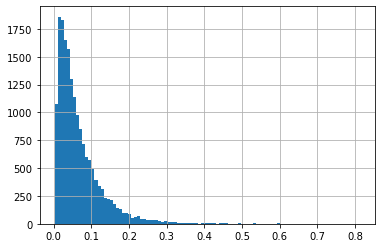

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
predictions.query("partition=='4'").query("split=='valid'").score_COX_clinical.hist(bins=100)

In [17]:
predictions.query("partition=='0'").query("split=='valid'").score_COX_MACE_clinical.hist(bins=100)

AttributeError: 'DataFrame' object has no attribute 'score_COX_MACE_clinical'

In [43]:
predictions.to_csv(f"{data_path}/3_datasets_post/{dataset_name}/predictions_coxph.csv", index=False)

In [85]:
predictions.tail()

,eid,score_COX_clinical,0_1_Ft_COX_clinical,0_2_Ft_COX_clinical,0_3_Ft_COX_clinical,0_4_Ft_COX_clinical,0_5_Ft_COX_clinical,0_6_Ft_COX_clinical,0_7_Ft_COX_clinical,0_8_Ft_COX_clinical,...,0_17_Ft_COX_clinical_pgs,0_18_Ft_COX_clinical_pgs,0_19_Ft_COX_clinical_pgs,0_20_Ft_COX_clinical_pgs,0_21_Ft_COX_clinical_pgs,0_22_Ft_COX_clinical_pgs,0_23_Ft_COX_clinical_pgs,0_24_Ft_COX_clinical_pgs,0_25_Ft_COX_clinical_pgs,0_26_Ft_COX_clinical_pgs
1978689,6025198,0.302564,0.021615,0.046786,0.075147,0.102025,0.130841,0.160260,0.189726,0.218453,...,0.396857,0.396857,0.396857,0.396857,0.396857,0.396857,0.396857,0.396857,0.396857,0.396857
1978685,6025198,0.300681,0.021327,0.046941,0.074294,0.100906,0.129106,0.158781,0.188204,0.217251,...,0.397130,0.397130,0.397130,0.397130,0.397130,0.397130,0.397130,0.397130,0.397130,0.397130
1978688,6025198,0.307658,0.022200,0.047657,0.075360,0.103045,0.132320,0.162574,0.192677,0.222838,...,0.400358,0.400358,0.400358,0.400358,0.400358,0.400358,0.400358,0.400358,0.400358,0.400358
1978687,6025198,0.308601,0.022987,0.048860,0.076584,0.104698,0.133883,0.163955,0.193831,0.223485,...,0.412981,0.412981,0.412981,0.412981,0.412981,0.412981,0.412981,0.412981,0.412981,0.412981
1978686,6025198,0.314298,0.023260,0.050451,0.079213,0.107872,0.137382,0.168453,0.199037,0.228170,...,0.412985,0.412985,0.412985,0.412985,0.412985,0.412985,0.412985,0.412985,0.412985,0.412985


In [87]:
predictions[["eid", "score_COX_clinical", 'partition', 'split']]

,eid,score_COX_clinical,partition,split
0,1000018,0.058907,0,train
2,1000018,0.058406,1,test
3,1000018,0.058947,2,train
4,1000018,0.057233,3,train
1,1000018,0.058583,4,train
...,...,...,...,...
1978689,6025198,0.302564,0,valid
1978685,6025198,0.300681,1,test
1978688,6025198,0.307658,2,valid
1978687,6025198,0.308601,3,valid


In [18]:
predictions_df = pd.read_feather("/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/models/benchmarks/BEN-1285/predictions/predictions.feather")

In [19]:
predictions_df

,0_1_ft,0_1_Ft,0_1_St,0_2_ft,0_2_Ft,0_2_St,0_3_ft,0_3_Ft,0_3_St,0_4_ft,...,0_23_Ft_calibrated,0_24_Ft_calibrated,0_25_Ft_calibrated,0_26_Ft_calibrated,eid,split,partition,module,net,datamodule
0,0.030803,0.022290,0.977710,0.039299,0.057751,0.942249,0.044319,0.099765,0.900235,0.047347,...,0.139802,0.146783,0.153930,0.161087,1000018,train,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
1,0.048185,0.036345,0.963655,0.058220,0.090192,0.909808,0.062842,0.151037,0.848963,0.064484,...,0.249414,0.260941,0.272834,0.283636,1000020,train,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
2,0.053468,0.040084,0.959916,0.064656,0.099897,0.900103,0.069494,0.167342,0.832658,0.070809,...,0.308261,0.322440,0.337083,0.349919,1000043,train,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
3,0.039807,0.029643,0.970357,0.049027,0.074585,0.925415,0.053833,0.126272,0.873728,0.056177,...,0.189116,0.198088,0.207313,0.216100,1000079,train,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
4,0.028805,0.021258,0.978742,0.036251,0.054144,0.945856,0.040689,0.092789,0.907211,0.043434,...,0.114073,0.119544,0.125108,0.130846,1000084,train,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395733,0.018039,0.013417,0.986583,0.022897,0.034085,0.965915,0.026106,0.058681,0.941319,0.028405,...,0.048910,0.051133,0.053338,0.055936,6024701,test,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
395734,0.041583,0.030703,0.969297,0.051509,0.077817,0.922183,0.056635,0.132170,0.867830,0.059054,...,0.213297,0.223581,0.234180,0.244097,6024778,test,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
395735,0.027671,0.019840,0.980160,0.035789,0.051936,0.948064,0.040801,0.090415,0.909585,0.044011,...,0.124349,0.130700,0.137188,0.143797,6024787,test,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212
395736,0.023525,0.017225,0.982775,0.029963,0.044256,0.955744,0.034002,0.076378,0.923622,0.036696,...,0.081644,0.085517,0.089424,0.093668,6024807,test,0,DeepSurvivalMachine,StandardMLP,CVDCoreVariablesWithPGSDataModule_210212


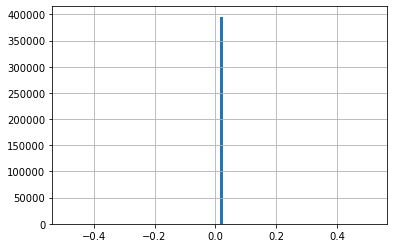

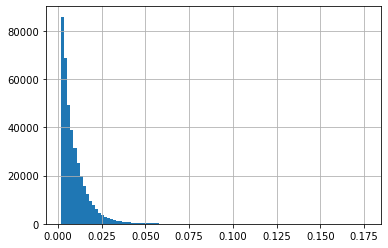

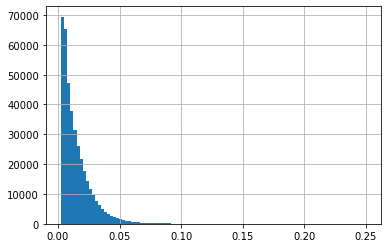

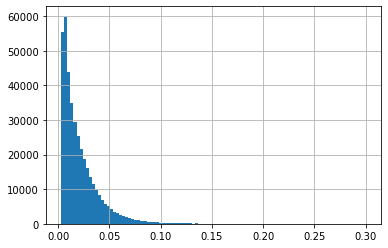

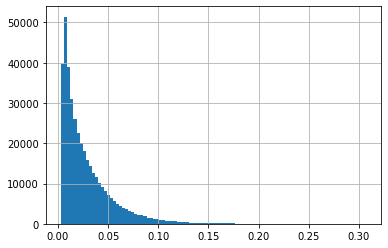

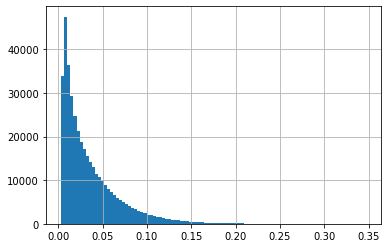

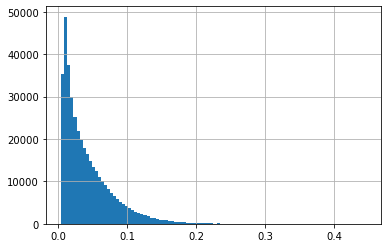

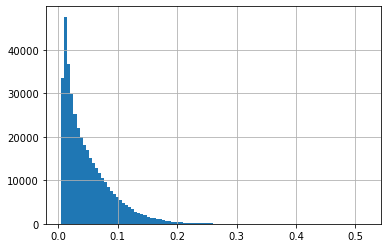

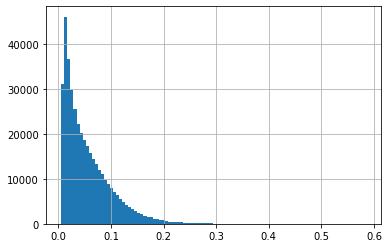

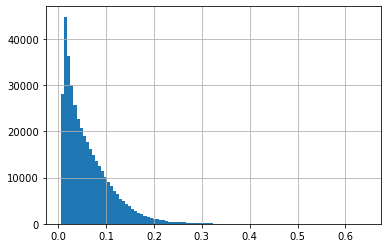

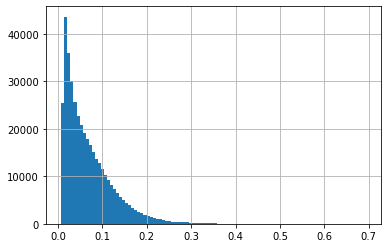

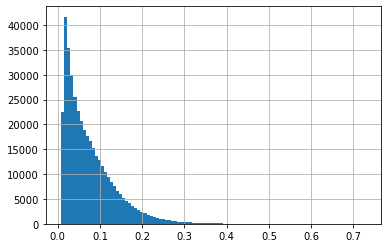

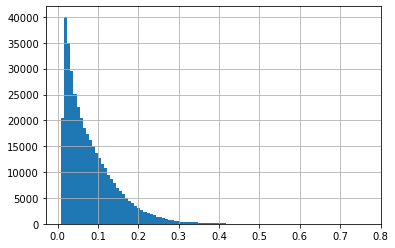

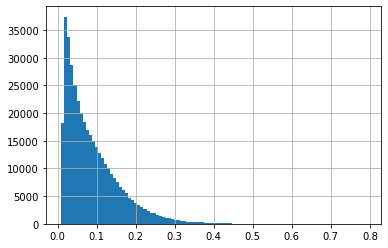

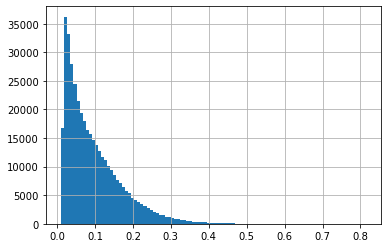

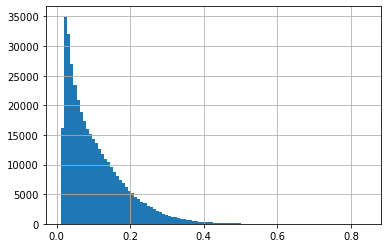

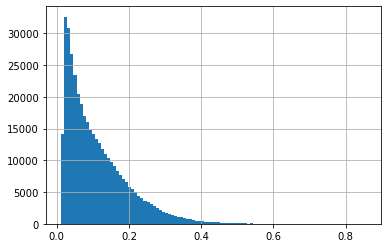

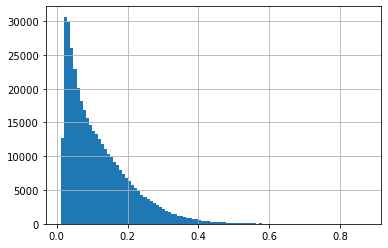

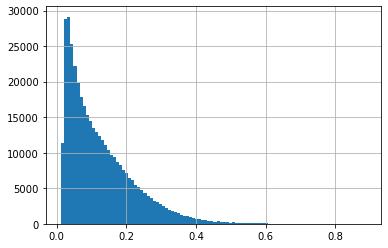

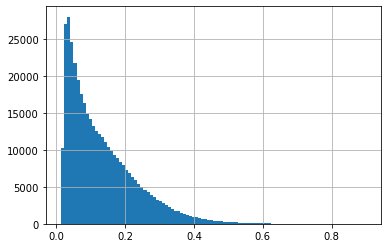

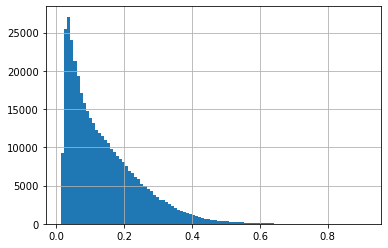

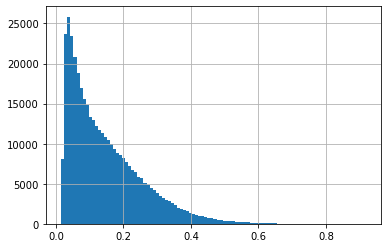

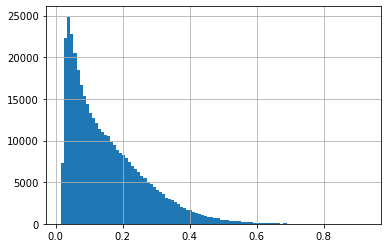

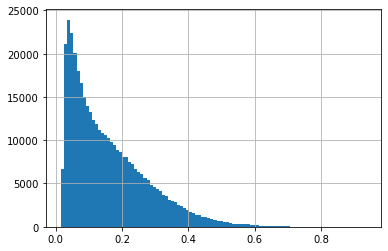

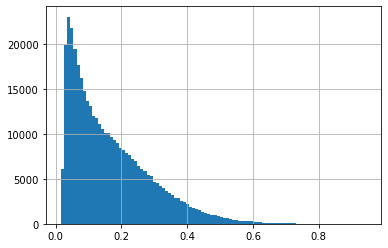

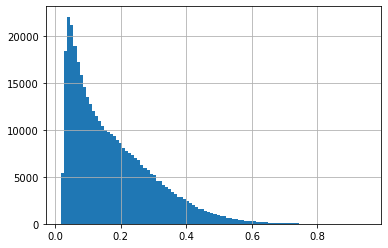

In [26]:
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)
for t in range(1, 27, 1):
    predictions_df[[col for col in predictions_df.columns.to_list() if f"_{t}_Ft" in col]+["partition", "split"]][f"0_{t}_Ft_calibrated"].hist(bins=100)
    plt.show()